# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
DATA_FOLDER = 'Data/' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

### Assumptions
   - Date : Where some days are missing the deaths and the new cases will be reported into the next report. Therefore, when we are asking for a *daily average per month*, this is computed using the sum of totals (for a given variable case or death) per month divided by the number of days in that month. With this assumption we must admit that our average will be bias in case of someone entering data from the last 2 days when being the first of a new month.We thus considered doing a linear regression in order to fill in the lack of data for a given month. Moreover, we only considered one feature per file represented as a "total" for the whole country. The data for each city being too noisy or missing in some file.
   - Therefore, for each country we found that the interesting variables and features to answer the question, would be :
       * For **Guinea**: 
           * Variables: *"Total cases of confirmed"* & *"Total deaths of confirmed"* 
           * Features: *"Totals"*
       * For **Liberia**:
           * Variables: *"Total confirmed cases"* & *"Total death/s in confirmed cases"* 
           * Features: *"National"*
       * For **Sierra Leone**: 
           * Variables: *"cum_confirmed"* & *death_confirmed"*
           * Features: *"National"*
      
    

In [2]:
# imports
%matplotlib inline
import pandas as pd
import os
import calendar
import numpy as np

In [3]:
# list all file in a directory ending with ext
def data_files(dir, ext):
    for root, dirs, files in os.walk(dir, topdown=False):
        r_files = [os.path.join(root, f) for f in files]
        for f in r_files:
            if f.endswith(ext):
                yield f

In [4]:
# Some constants
COUNTRIES = ['guinea_data', 'sl_data', 'liberia_data']
EBOLA_FOLDER = os.path.join(DATA_FOLDER, 'ebola')
COUNTRY_FOLDERS = [os.path.join(EBOLA_FOLDER, country) for country in COUNTRIES]

In [5]:
# For each Country import the data in a dataFrame
df_guinea = pd.concat([pd.read_csv(f) for f in data_files(COUNTRY_FOLDERS[0], '.csv')])
df_sl = pd.concat([pd.read_csv(f) for f in data_files(COUNTRY_FOLDERS[1], '.csv')])
df_liberia = pd.concat([pd.read_csv(f) for f in data_files(COUNTRY_FOLDERS[2], '.csv')])

# Rename columns of interest
df_guinea = df_guinea.rename(columns={})
df_sl = df_sl.rename(columns={'variable': 'Description', 'National': 'Totals', 'date': 'Date'})
df_liberia = df_liberia.rename(columns={'National': 'Totals', 'Variable': 'Description', 'date': 'Date'})

#add a Country columns (usefull for future groupby)
df_guinea["Country"] = "Guinea"
df_sl["Country"] = "SL"
df_liberia["Country"] = "Liberia"

Here we make the assumption that only the confirmed cases and deaths are of interest

In [6]:
#Define some interesting value from the Description columns

death_desc = ["Total deaths of confirmed", "death_confirmed", "Total death/s in confirmed cases"]
case_desc = ["Total cases of confirmed", "cum_confirmed", "Total confirmed cases"]

In [7]:
# Merge dataframe per contry in one single dataframe
df = pd.concat([df_guinea, df_sl, df_liberia])

#convert all date into datetime
df["Date"] = pd.to_datetime(df["Date"])

#Remove unwanted chars from the Totals columns and convert it into numeric type (float)
df["Totals"] = df["Totals"].replace("%|,|-|[A-Z]|[a-z]", "", regex=True).replace("", 0, regex=True).fillna(0).astype(float)

#Remove uninteresting rows and select relevant columns
df_selection = df[(df["Description"].isin(death_desc)) | (df["Description"].isin(case_desc))][["Country", "Date", "Description", "Totals"]]
df_selection["Description"] = df_selection["Description"].apply(lambda x: "Death" if x in death_desc else ("Case" if x in case_desc else "Error"))

df_selection = df_selection.pivot_table(index=["Country", "Date"], columns="Description", values="Totals").dropna()

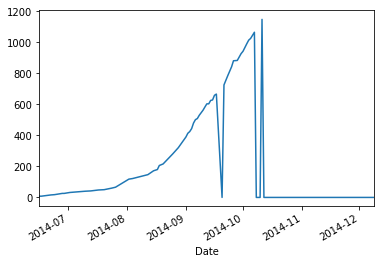

In [8]:
df_selection.loc[("Liberia")]["Death"].plot()

In [9]:
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
import datetime

C:\Users\Thomas\Anaconda3\envs\ada\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
def date_to_sec(date):
    return (date-datetime.datetime(2013, 1, 1,)).total_seconds()

def feature_expends(X):
    X["Date"] = X["Date"] / 5000000
    X["exp"] = 0.5 * (X["Date"].apply(np.exp))
    return X

def get_model(data, sel):
    reg = linear_model.RANSACRegressor(min_samples = 0.9, random_state=2) # doesn't take into acount outliers
    
    #Remove zeros from the data
    data_no_zero = data[data[sel]>0]
    
    X = pd.DataFrame()
    #convert datetime into seconds (better for regression)
    X["Date"] = pd.DataFrame(data_no_zero[sel].index)["Date"].apply(date_to_sec)
    X = feature_expends(X)
    
    x_train, x_test, y_train, y_test = train_test_split(X, data_no_zero[sel], test_size=0.1, random_state=34)
    
    reg.fit(x_train, y_train)
    return reg, X

def get_inlier(data, sel):
    """Return a mask for the inlier"""
    reg = linear_model.RANSACRegressor(min_samples = 0.9, random_state=2)
    data_no_zero = data[data[sel]>0]
    X = pd.DataFrame()
    X["Date"] = pd.DataFrame(data_no_zero[sel].index)["Date"].apply(date_to_sec)
    X = feature_expends(X)
    x_train, x_test, y_train, y_test = train_test_split(X, data_no_zero[sel], test_size=0.1, random_state=34)
    reg.fit(x_train, y_train)
    return reg.inlier_mask_
    
def plot_with_model(data, sel, title="None"):
    reg, X = get_model(data, sel)
    data_no_zero = data[data[sel]>0]
    
    diff = pd.DataFrame(reg.predict(X)).rename(columns={0:"Prediction"})
    diff["Real Values"] = data_no_zero[sel].values
    diff.index = X["Date"]
    diff.plot(title=title)

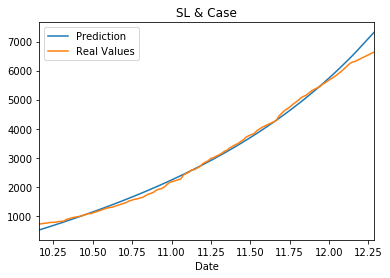

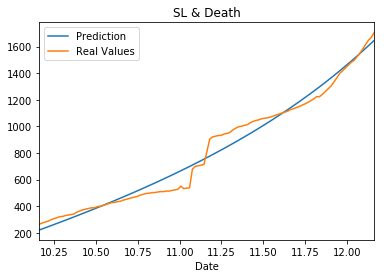

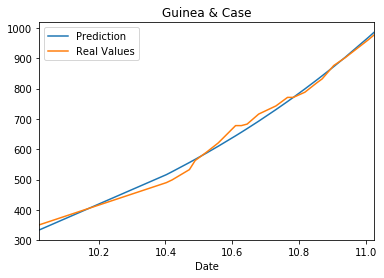

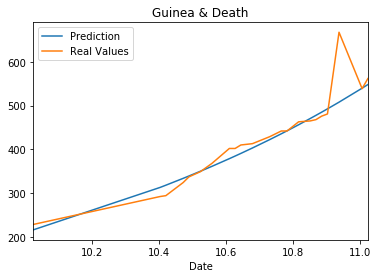

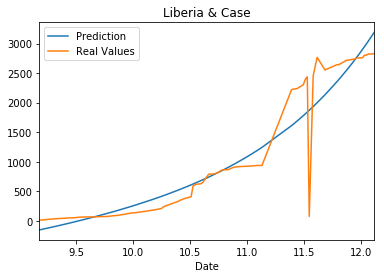

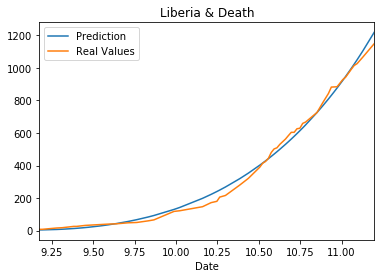

In [11]:
for c in ["SL", "Guinea", "Liberia"]:
    for sel in ["Case", "Death"]:
        plot_with_model(df_selection.loc[c], sel, c + " & " + sel)

## Daily average per month using Linear regression

We first use Linear regression to deal with the amount of missing data. The corresponding daily average per month of death/cases should be more accurate than a naive approach. Thanks to the regression we were able to take the ratio between the presumed death over the **whole** months.

In [12]:
for c in ["SL", "Guinea", "Liberia"]:
    for sel in ["Case", "Death"]:
        reg, _ = get_model(df_selection.loc[c], sel)
        months = df_selection.loc[c].reset_index()["Date"].dt.month.unique()
        months.sort()
        print(c + " for "+ sel + " has per month :")
        for m in months:
            nb_day = calendar.monthrange(2014, m)[1]
            dt_start = datetime.datetime(2014, m, 1)
            dt_end = dt_start + datetime.timedelta(int(nb_day))
            X = pd.DataFrame({"Date": [dt_start, dt_end]})
            X["Date"] = X["Date"].apply(date_to_sec)
            X = feature_expends(X)
            pred = reg.predict(X)
            mean = (pred[1] - pred[0]) / nb_day
            print("  " + str(m) + ": " + str(mean))      

SL for Case has per month :
  8: 30.4497493355
  9: 38.3709573917
  10: 51.8281877239
  11: 74.5567805233
  12: 113.170071104
SL for Death has per month :
  8: 8.14426056109
  9: 9.63583230088
  10: 12.16984281
  11: 16.4496605428
  12: 23.7205834376
Guinea for Case has per month :
  8: 8.50664983093
  9: 13.6126515159
  10: 22.2871668502
Guinea for Death has per month :
  8: 4.52221471042
  9: 6.79427982208
  10: 10.6542596787
Liberia for Case has per month :
  6: 7.25986468441
  7: 8.98237696277
  8: 11.9587262783
  9: 16.9294778278
  10: 25.3742185858
  11: 39.6369657669
  12: 63.867748827
Liberia for Death has per month :
  6: 0.263508417627
  7: 3.45437414328
  8: 8.96790872746
  9: 18.1759712471
  10: 33.8194207513
  11: 60.240429011
  12: 105.126712925


## Daily average per month using conventional method

This time we took a more naive approach were we used only the available data. This means that we summed up the total death/case of a month and divided by the number of days of the last date of available data.

The resulting averages are of course a little bit biased.

In [13]:
df_selection["CasePerDay"] = (df_selection[["Case"]] - df_selection[["Case"]].shift(1))
df_selection["DeathPerDay"] = (df_selection[["Death"]] - df_selection[["Death"]].shift(1))
#Remove outliers
df_selection["CasePerDay"] = df_selection[(df_selection["CasePerDay"] >=0) & (df_selection["CasePerDay"] < 500)]["CasePerDay"]
df_selection["DeathPerDay"] = df_selection[(df_selection["DeathPerDay"] >=0) & (df_selection["DeathPerDay"] < 500)]["DeathPerDay"]
df_selection = df_selection.dropna().reset_index()
#Create a commun date per month
df_selection["Date_month"] =  df_selection["Date"].apply(lambda x: x.replace(day = 1))

#Compute the number of days for witch we have some data
summe = df_selection.groupby(["Country", "Date_month"]).sum()[["CasePerDay", "DeathPerDay"]].sort_index()
minimum = df_selection.groupby(["Country", "Date_month"]).min()[["Date"]].sort_index()
maximum = df_selection.groupby(["Country", "Date_month"]).max()[["Date"]].sort_index()
diff = maximum - minimum
diff['Date'] = diff['Date'].apply(lambda x: x + np.timedelta64(1, 'D'))

In [14]:

summe["DeathPerDay"] = summe["DeathPerDay"] / (diff["Date"].dt.days)
summe["CasePerDay"] = summe["CasePerDay"] / (diff["Date"].dt.days)
summe.sort_index()

Description         CasePerDay  DeathPerDay
Country Date_month                         
Guinea  2014-08-01   35.333333    18.166667
        2014-09-01   13.560000    13.240000
        2014-10-01   16.000000    23.000000
Liberia 2014-06-01    2.384615     1.384615
        2014-07-01    1.884615     1.538462
        2014-08-01   10.259259     9.444444
        2014-09-01   17.766667    18.266667
        2014-10-01    7.700000     4.600000
        2014-11-01   21.148148     0.000000
        2014-12-01    0.777778     0.000000
SL      2014-08-01   14.105263     5.052632
        2014-09-01   31.400000     4.266667
        2014-10-01   59.448276    18.551724
        2014-11-01   55.310345    12.344828
        2014-12-01   81.000000    35.333333

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [15]:
# Write your answer here

metadatasheet = os.path.join(os.path.join(DATA_FOLDER, "microbiome"), "metadata.xls")
df_metadata = pd.read_excel(metadatasheet)

root = os.path.join(DATA_FOLDER, "microbiome/")
rows = [row for (i, row) in df_metadata.iterrows()]
df_spreasheets = [pd.read_excel(root + r.BARCODE + ".xls", header=None, index_col=0, names=[str(r.GROUP) + " " +str(r.SAMPLE)]) for r in rows]

conc = pd.concat(df_spreasheets, axis = 1).fillna('unknown') #.index.is_unique

conc.index = [conc.index.map(lambda x: x.split(' ')[i] if i < 5 else ",".join(x.split(" ")[i:])) for i in range(6)]
conc

EXTRACTION CONTROL nan  \
Archaea  "Crenarchaeota"         Thermoprotei          Acidilobales             Acidilobaceae                     Acidilobus                                        unknown   
                                                                                Caldisphaeraceae                  Caldisphaera                                      unknown   
                                                       Desulfurococcales        Desulfurococcaceae                Ignisphaera                                             7   
                                                                                                                  Stetteria                                         unknown   
                                                                                                                  Sulfophobococcus                                  unknown   
                                                                                                                  Thermodiscus                                      unknown   
                                                                                                                  Thermosphaera                                     unknown   
                                                                                Pyrodictiaceae                    Hyperthermus                                      unknown   
                                                                                                                  Pyrodictium                                       unknown   
                                                                                                                  Pyrolobus                                               2   
                                                       Sulfolobales             Sulfolobaceae                     Stygiolobus                                             3   
                                                                                                                  Sulfurisphaera                                    unknown   
                                                       Thermoproteales          Thermofilaceae                    Thermofilum                                             3   
                                                                                Thermoproteaceae                  Caldivirga                                        unknown   
                                                                                                                  Thermocladium                                     unknown   
         "Euryarchaeota"         "Methanomicrobia"     Methanocellales          Methanocellaceae                  Methanocella                                            7   
                                                       Methanomicrobiales       Methanomicrobiaceae               Methanomicrobium                                  unknown   
                                                                                                                  Methanosphaerula                                  unknown   
                                                                                Methanomicrobiales_incertae_sedis Methanolinea                                      unknown   
                                                                                Methanospirillaceae               Methanospirillum                                  unknown   
                                                       Methanosarcinales        Methanosarcinaceae                Methanimicrococcus                                      1   
                                                                                                                  Methanosalsum                                     unknown   
                                                                                Methermicoccaceae                 Methermico

In [16]:
#Index is unique

conc.index.is_unique

True

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [17]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('notebook')

## Assumptions:

We made some assumptions regarding the data from the Titanic. Namely, as there are a lot of NaN for cabins, we didn't take them into account when plotting the proportion of pasengers per floor. Same goes for the ages when plotting the numbers per decades.


In [19]:
# Write your answer here
data = pd.read_excel(DATA_FOLDER + "/titanic.xls")
data["embarked"] = data["embarked"].astype('category')
data["sex"] = data["sex"].astype('category')
data['survived'] = data['survived'].astype('category')
data['pclass'] = data['pclass'].astype('category')
data["cabin"] = data["cabin"].fillna("Z").astype(str)
data.dtypes

pclass       category
survived     category
name           object
sex          category
age           float64
sibsp           int64
parch           int64
ticket         object
fare          float64
cabin          object
embarked     category
boat           object
body          float64
home.dest      object
dtype: object

#### Question 3.1 
##### According to the method describe() used bellow we have as :
* Integer attributes : 
    * pclass range [1,3], 
    * survived [0;1], 
    * sibsp (Number of Siblings/Spouses Aboard) range [0,8] 
    * parch (Number of Parents/Children Aboard) range [0,9]
* Float attributes : 
    * age in year, range [0.166700, 80.00]
    * fare range [0.00, 512.32]
    * body in pound, range [1, 328]
* String : 
    * cabin
    * embarked
    * home.dest
* Object : 
    * ticket (Number) 
    * boat 
   
* A categorical variable can take on only a limited, and usually fixed, number of possible values. Hence we chose the following variables as categorical:
    * pclass
    * survived
    * sex
    * embarked
    * age (if seperated in different ranges)

##### 3.1.bis Features that contain NaN values 

pclass False <br>
survived False <br>
name False <br>
sex False <br>
age True <br>
sibsp False <br>
parch False <br>
ticket False <br>
fare True <br>
cabin True <br>
embarked True <br>
boat True <br>
body True <br>
home.dest True

In [20]:
data.describe()

,age,sibsp,parch,fare,body
count,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,29.881135,0.498854,0.385027,33.295479,160.809917
std,14.413500,1.041658,0.865560,51.758668,97.696922
min,0.166700,0.000000,0.000000,0.000000,1.000000
25%,21.000000,0.000000,0.000000,7.895800,72.000000
50%,28.000000,0.000000,0.000000,14.454200,155.000000
75%,39.000000,1.000000,0.000000,31.275000,256.000000
max,80.000000,8.000000,9.000000,512.329200,328.000000


#### Question 3.2 : Histograms

In [21]:
#Methods used to plot the pie charts and histograms as 

def show_pie_chart(X, sel, title = "title"):
    x_list = pd.DataFrame(data[sel].value_counts())
    plt.pie(x_list[sel],labels=x_list.index,autopct="%1.1f%%") 
    plt.title(title)
    plt.show()
def plot_hist(X, sel, bins = 20 ,title = 'title'):
    plt.hist(X[sel],bins = bins) 
    plt.title(title)
    plt.show()

###### Travel class histogram

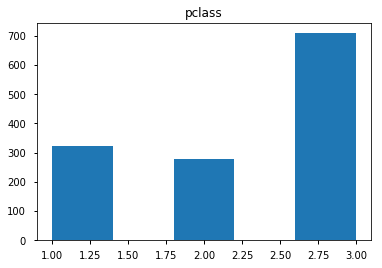

In [22]:
plot_hist(data, sel = "pclass", title = "pclass", bins=5)

###### Embarkation port histogram

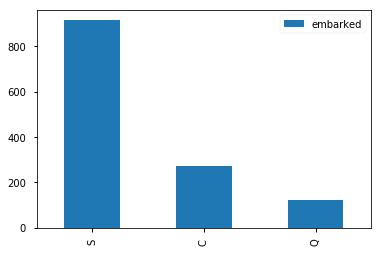

In [23]:
pd.DataFrame(data['embarked'].value_counts()).plot(kind='bar')

###### Sex histogram

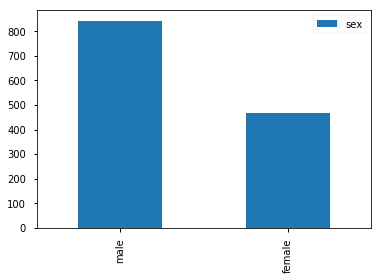

In [24]:
pd.DataFrame(data['sex'].value_counts()).plot(kind='bar')

###### Age histogram

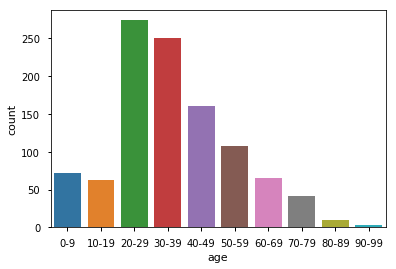

In [25]:
label_cuts =['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99']
age = pd.DataFrame(pd.cut(data[pd.notnull(data.age)]['age'], bins=10, labels=label_cuts))
sns.countplot( x='age', data=age)

###### Qestion 3 :  Proportion of passengers by cabin floor

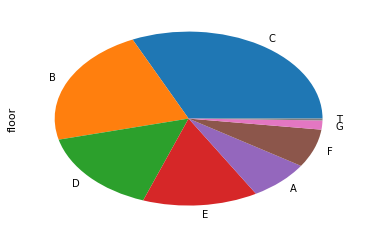

In [26]:
data["floor"] = data.apply(lambda x: x["cabin"][0], axis = 1)
#In the preprocessing step, loading the data we have allocated the unknown values of the cabin to "Z"
data[data['floor'] != "Z"]["floor"].value_counts().plot(kind='pie')


##### Question 4 : Proportion of passengers that survived by class 

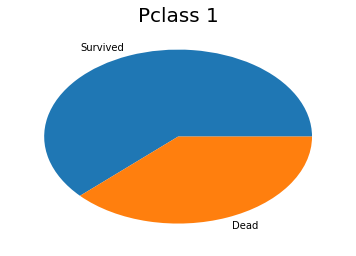

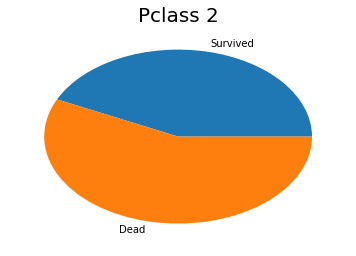

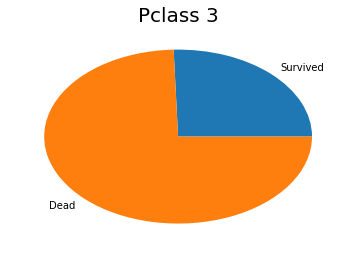

In [27]:
data['survived'] = data['survived'].astype('int')
data['pclass'] = data['pclass'].astype('int')
survivors = data.loc[:,['survived', 'pclass']].set_index('pclass')
survivors['died'] = survivors.apply(lambda x:  0 if x['survived']==1 else 1, axis=1)
survivors = survivors.groupby('pclass')['survived', 'died'].sum()

for index, row in survivors.iterrows():
    fig = plt.figure()
    plt.title('Pclass '+str(index), fontsize=20)
    plt.pie(x=row, labels=['Survived', 'Dead'])
    

##### Question 5 : Proportion of the passengers that survived by travel class and sex

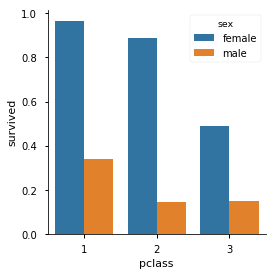

In [28]:
grp = data.groupby(["sex", "pclass"])["survived"].mean().reset_index().set_index(["sex", "pclass"])
t = grp.reset_index()
sns.factorplot(x="pclass", y="survived", hue="sex", data=t, kind="bar", legend_out=False)

 ##### Question 6  : survival proportions by age category, travel class and sex

In [29]:
data["age_cat"] = pd.qcut(data["age"],q=2, labels=["young","old"])
sel = ["age_cat", "pclass", "sex"]
data.groupby(sel)["survived"].mean().reset_index().set_index(sel) 

survived
age_cat pclass sex             
young   1      female  0.951220
               male    0.531250
        2      female  0.910714
               male    0.216216
        3      female  0.513761
               male    0.183036
old     1      female  0.967391
               male    0.302521
        2      female  0.872340
               male    0.083333
        3      female  0.372093
               male    0.144000